In [ ]:
#pip install langfuse-haystack

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich

from dotenv import load_dotenv

load_dotenv()

HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")



In [2]:
# Fallbacks with Branching Pipelines
from haystack import Pipeline

from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack_integrations.components.connectors.langfuse import LangfuseConnector

from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder

from haystack.utils import Secret


document_store = ElasticsearchDocumentStore(hosts = "http://localhost:9200")
rag_prompt_template = """
Answer the following query given the documents.
If the answer is not contained within the documents, reply with 'no_answer'
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

query_embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever =ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 3)
prompt = PromptBuilder(template=rag_prompt_template)
generator = OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))

rag = Pipeline()

rag.add_component("tracer", LangfuseConnector("Basic RAG Pipeline"))
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever",retriever )
rag.add_component("prompt_builder", prompt)
rag.add_component("llm", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder", "llm")


Langfuse client is disabled since no public_key was provided as a parameter or environment variable 'LANGFUSE_PUBLIC_KEY'. See our docs: https://langfuse.com/docs/sdk/python/low-level-sdk#initialize-client


🚅 Components
  - tracer: LangfuseConnector
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: ElasticsearchEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

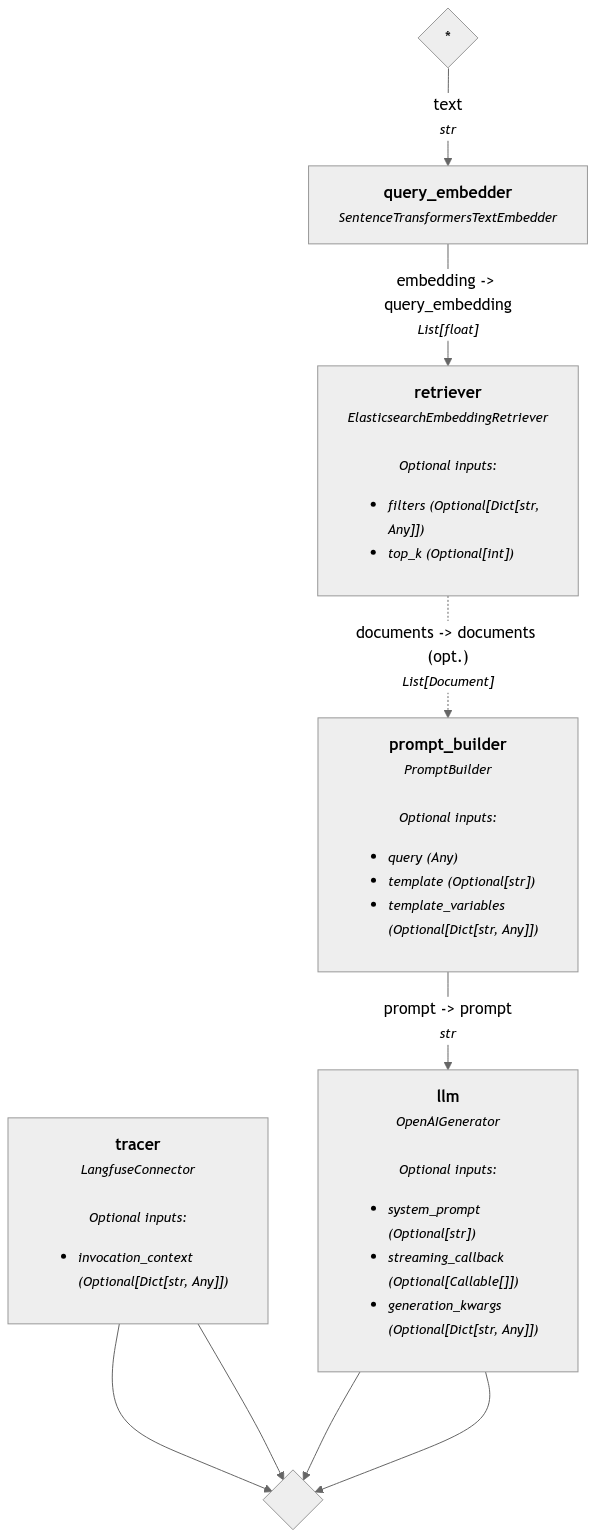

In [3]:
rag.show()

In [4]:
document_store.count_documents()

55

In [6]:
query = "Who is J. R.R. Tolkien?"

result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query}},
        include_outputs_from={"tracer"}
)


rich.print(result["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the
most influential and celebrated figures in literary history, particularly within the realm of high fantasy.

In [7]:
result

{'tracer': {'name': 'Basic RAG Pipeline',
  'trace_url': 'https://cloud.langfuse.com/trace/d62ac282-29a6-4310-8599-a6047e0573f2'},
 'llm': {'replies': ['John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the most influential and celebrated figures in literary history, particularly within the realm of high fantasy.'],
  'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 49,
     'prompt_tokens': 157,
     'total_tokens': 206,
     'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0},
     'completion_tokens_details': {'reasoning_tokens': 0,
      'audio_tokens': 0,
      'accepted_prediction_tokens': 0,
      'rejected_prediction_tokens': 0}}}]}}